This script calculates the daily likelihood of wetting rain and 95th percentile wind for every grid cell in reanalysis

It was run on a server, it would be very slow on a local machine.

In [1]:
import xarray as xr
import cftime
import pandas as pd
import numpy as np
import netCDF4
import os
import scipy
import metpy

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


In [2]:
model_directory = '/model_directory/'
directory = model_directory
pr_dir = directory+'/pr/era5_pr_1981_2010.nc'
pr = xr.open_dataset(pr_dir)
wind_dir = directory+'/sfcWind/era5_sfcWind_1981_2010.nc'
sfcWind = xr.open_dataset(wind_dir)
coords = xr.open_dataset('/wrfinput_d02_coord.nc')

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


# Rain

In [ ]:
sfcWind_vals = sfcWind.wspd10mean
pr_vals = pr.prec

testing_percentile = .95
# calculate 2 week trailing precipitation for July-November
months = [5,6,7,8,9,10,11]
time_index = [i for i, month in enumerate(pr_vals.day.dt.month) if month in months]
new_dataset = pr_vals.isel(day = time_index)
window = 14
shifted = new_dataset.rolling(day=window,center=False).construct("window")
trailprtotal = shifted.sum(dim='window')
# remove July
months = [6,7,8,9,10,11]
time_index = [i for i, month in enumerate(trailprtotal.day.dt.month) if month in months]
trailprtotal = trailprtotal.isel(day = time_index)

lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])


# Choose a bounding box
# Create latitude and longitude masks
latmask = (lat_wrf > 35) & (lat_wrf < 37)
lonmask = (lon_wrf > -118) & (lon_wrf < -116)

# Apply masks to trailprtotal using where method
subset_array = trailprtotal
#subset_coords = coords.where(latmask & lonmask,drop=True)

# find average likelihoods

# Define the start and end dates for the desired range
start_date = '1981-06-01'
end_date = '2010-11-30'

# Extract the month and day parts from the start and end dates
start_month_day = start_date[5:]
end_month_day = end_date[5:]

# Initialize lists to store proportions and wdprops
proportions = []
wdprops = []
wdprop_nots = []
cumulatives = []
alldates = []
# Loop over each date within the specified range
current_date = start_date
count=0
while current_date[5:] < end_month_day:
    # Create a boolean mask for selecting the current date
    date_mask = subset_array.day.dt.strftime('%m-%d') == current_date[5:]
    # Select the subset of data for the current date
    subset_data = subset_array.where(date_mask,drop=True)

    # Count data > 12
    wetdays = sum(subset_data.values > 12)
    proportion = wetdays / len(subset_data)
    proportions.append(proportion)
    
    # Increment to the next day
    current_date = (pd.to_datetime(current_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
proportions = xr.DataArray(proportions,dims=['day','lat2d', 'lon2d'])


    
zeros_mask = (proportions == 0).all(dim='day')
# Remove the lat-lon points where the entire 'day' dimension is 0
proportions = proportions.where(~zeros_mask, drop=True)



# merge into a dataset

data_dict = {'rain': proportions}
dataset = xr.Dataset(data_dict)

# save file

dataset.to_netcdf('/era5/entire_domain_wind_rain_only.nc')

# Wind

In [ ]:
model_directory = '/ERA5/'


directory = model_directory
wind_dir = directory+'/sfcWind/era5_sfcWind_1981_2010.nc'
sfcWind = xr.open_dataset(wind_dir)
coords = xr.open_dataset('/wrfinput_d02_coord.nc')

sfcWind_vals = sfcWind.wspd10mean

testing_percentile = .95


UV = sfcWind_vals
wind_prctiles = UV.quantile(testing_percentile,dim="day")
months = [6,7,8,9,10,11]
time_index = [i for i, month in enumerate(UV.day.dt.month) if month in months]
UV = UV.isel(day = time_index)

# limit wind dataset to ASON
# speed exceeds the wind percentile for each grid cell
wd = xr.where(UV > wind_prctiles,1,0)


#subset_coords = coords.where(latmask & lonmask,drop=True)
subset_wind = wd

# find average likelihoods

# Define the start and end dates for the desired range
start_date = '1981-06-01'
end_date = '2010-11-30'

# Extract the month and day parts from the start and end dates
start_month_day = start_date[5:]
end_month_day = end_date[5:]

# Initialize lists to store proportions and wdprops
proportions = []
wdprops = []
wdprop_nots = []
cumulatives = []
alldates = []
# Loop over each date within the specified range
current_date = start_date
count=0
while current_date[5:] < end_month_day:
    # Create a boolean mask for selecting the current date
    date_mask = subset_wind.day.dt.strftime('%m-%d') == current_date[5:]
    # Select the subset of data for the current date
    
    wdsubset = subset_wind.where(date_mask,drop=True)
    # Count data > 12
    
    wddays = sum(wdsubset == 1)
    # on this date, what is the likelihood of strong wind, based on climatology
    wdprop = wddays / len(wdsubset)
    wdprops.append(wdprop)
    # what is the chance that this day does NOT have strong wind

    # Increment to the next day
    current_date = (pd.to_datetime(current_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    

wdprops = xr.DataArray(wdprops,dims=['day','lat2d', 'lon2d'])


# cumulative likelihood calculation


zeros_mask = (wdprops == 0).all(dim='day')
# Remove the lat-lon points where the entire 'day' dimension is 0
wdprops = wdprops.where(~zeros_mask, drop=True)


# merge into a dataset

data_dict = {'wind': wdprops}
dataset = xr.Dataset(data_dict)
dataset.to_netcdf('/era5/entire_domain_wind_all_year.nc')

## Plotting

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import cftime
import pandas as pd
import cftime
import numpy as np
import netCDF4
import os
import cartopy.feature as cfeature
import scipy.stats as stats
from scipy.stats import rankdata
from scipy.stats import mannwhitneyu
import matplotlib.patches as mpatches
import datetime
from scipy.stats import gaussian_kde
import datetime
import matplotlib.ticker as ticker

In [3]:
# Build some custom colormaps
import matplotlib.colors

model_eval = matplotlib.colors.ListedColormap(["royalblue","cornflowerblue","lightskyblue","lightcyan","mistyrose","lightcoral","indianred","firebrick"])
rain_map = matplotlib.colors.ListedColormap(["sienna","sandybrown","peachpuff","linen","lightgreen","limegreen","forestgreen","darkgreen"])
hist_rain_map = matplotlib.colors.ListedColormap(["saddlebrown","sienna","sandybrown","peachpuff","linen","honeydew","lightgreen","limegreen","forestgreen","darkgreen"])
rain_change = matplotlib.colors.ListedColormap(["royalblue","cornflowerblue","lightskyblue","lightcyan","mistyrose","lightcoral","indianred","firebrick"])
light_rain_map2 = matplotlib.colors.ListedColormap(["goldenrod","burlywood","peachpuff","linen","seashell","honeydew","palegreen","lightgreen","limegreen","forestgreen"])

In [4]:
# load in data
coords = xr.open_dataset('/wrfinput_d02_coord.nc')
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
# Generate the date range from June 1st to November 30th
start_date = datetime.date(2023, 6, 1)
end_date = datetime.date(2023, 12, 30)
delta = datetime.timedelta(days=1)

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date)
    current_date += delta
tick_positions = []
tick_labels = []

for i, date in enumerate(dates):
    if date.day == 1:
        tick_positions.append(i)
        tick_labels.append(date.strftime('%m/%d'))

## Calculate transects for rain

In [6]:
era5_likelihood = xr.open_dataset('/era5/entire_domain_rain_only.nc')
era5_likelihood_wind = xr.open_dataset('/era5/entire_domain_wind_all_year.nc')

In [7]:
era5_likelihood = xr.open_dataset('/era5/entire_domain_rain_only.nc')
era5_likelihood_wind = xr.open_dataset('/likelihood_curves/era5/entire_domain_wind_all_year.nc')

# Try a heatmap of latitudinal bands
lat_lon_ranges = [((51, 51.5), (-127, -123.5)),
                  ((50.5, 51), (-126, -123)),
                  ((50, 50.5), (-124.5, -122)),
                  ((49.5, 50), (-123.25, -121.5)),
                  ((49, 49.5), (-123, -120.75)),
                  ((48.5, 49), (-123, -120.75)),
                  ((48, 48.5), (-123, -121)),
                  ((47.5, 48), (-124.25, -121)),
                  ((47, 47.5), (-124.25, -121)),
                  ((46.5, 47), (-124, -121.5)),
                  ((46, 46.5), (-124, -121.5)),
                  ((45.5, 46), (-124, -121.5)),
                  ((45, 45.5), (-124, -121.5)),
                  ((44.5, 45), (-124, -121.5)),
                  ((44, 44.5), (-124, -121.5)),
                  ((43.5, 44), (-124, -122)),
                  ((43, 43.5), (-124.5, -122)),
                  ((42.5, 43), (-124.5, -122)),
                  ((42, 42.5), (-124.5, -122)),
                  ((41.5, 42), (-124, -122)),
                  ((41, 41.5), (-124, -122)),
                  ((40.5, 41), (-124.25, -121)),
                  ((40, 40.5), (-124.25, -121)),
                  ((39.5, 40), (-124, -120)),
                  ((39, 39.5), (-124, -120)),
                  ((38.5, 39), (-123.75, -120)),
                  ((38, 38.5), (-123.5, -119.5)),
                  ((37.5, 38), (-123, -119)),
                  ((37, 37.5), (-123, -118.75)),
                  ((36.5, 37), (-122, -118.25)),
                  ((36, 36.5), (-122, -118.25)),
                  ((35.5, 36), (-121.5, -118.5)),
                  ((35, 35.5), (-121.5, -118.5)),
                  ((34.5, 35), (-120.5, -118.5)),
                  ((34, 34.5), (-119.5, -116.75)),
                  ((33.5, 34), (-118.5, -116.5)),
                  ((33, 33.5), (-117.5, -116.5)),
                  ((32.5, 33), (-117.5, -116.5))]

era5_means = []

for lat_range, lon_range in lat_lon_ranges:
    latmask = (lat_wrf > lat_range[0]) & (lat_wrf < lat_range[1])
    lonmask = (lon_wrf > lon_range[0]) & (lon_wrf < lon_range[1])
    era5_subset = era5_likelihood.where(latmask & lonmask, drop=True)
    era5_mean = era5_subset.mean(dim=['lat2d', 'lon2d'])
    era5_means.append(era5_mean)

# Now era5_means contains all the mean values for each latitude and longitude range
window_size = 1
era5_avg_rains = []  # Create a list to store the averaged rain DataArrays

for era5_mean in era5_means:
    era5_avg_rain = era5_mean.rain
    era5_avg_rain = era5_avg_rain.rolling(day=window_size, center=True).mean()
    era5_avg_rains.append(era5_avg_rain)

heatmap_data = xr.concat(era5_avg_rains,dim='transect')

# replace the index values with latitude values
# Define the latitude ranges from lat_lon_ranges
latitudes = [np.mean(lat_range) for lat_range, _ in lat_lon_ranges]

# Create a new DataArray with updated transect values
new_transect = xr.DataArray(latitudes, dims='transect')

# Update the heatmap_data with the new transect values
heatmap_data['transect'] = new_transect

## Calculate transects for wind

In [8]:
first_wind_era5 = xr.open_dataset('/era5/era5_1981_2010_first_wind.nc')
first_wind_era5 = first_wind_era5.wspd10mean

# Try a heatmap of latitudinal bands
lat_lon_ranges = [((51, 51.5), (-127, -123.5)),
                  ((50.5, 51), (-126, -123)),
                  ((50, 50.5), (-124.5, -122)),
                  ((49.5, 50), (-123.25, -121.5)),
                  ((49, 49.5), (-123, -120.75)),
                  ((48.5, 49), (-123, -120.75)),
                  ((48, 48.5), (-123, -121)),
                  ((47.5, 48), (-124.25, -121)),
                  ((47, 47.5), (-124.25, -121)),
                  ((46.5, 47), (-124, -121.5)),
                  ((46, 46.5), (-124, -121.5)),
                  ((45.5, 46), (-124, -121.5)),
                  ((45, 45.5), (-124, -121.5)),
                  ((44.5, 45), (-124, -121.5)),
                  ((44, 44.5), (-124, -121.5)),
                  ((43.5, 44), (-124, -122)),
                  ((43, 43.5), (-124.5, -122)),
                  ((42.5, 43), (-124.5, -122)),
                  ((42, 42.5), (-124.5, -122)),
                  ((41.5, 42), (-124, -122)),
                  ((41, 41.5), (-124, -122)),
                  ((40.5, 41), (-124.25, -121)),
                  ((40, 40.5), (-124.25, -121)),
                  ((39.5, 40), (-124, -120)),
                  ((39, 39.5), (-124, -120)),
                  ((38.5, 39), (-123.75, -120)),
                  ((38, 38.5), (-123.5, -119.5)),
                  ((37.5, 38), (-123, -119)),
                  ((37, 37.5), (-123, -118.75)),
                  ((36.5, 37), (-122, -118.25)),
                  ((36, 36.5), (-122, -118.25)),
                  ((35.5, 36), (-121.5, -118.5)),
                  ((35, 35.5), (-121.5, -118.5)),
                  ((34.5, 35), (-120.5, -118.5)),
                  ((34, 34.5), (-119.5, -116.75)),
                  ((33.5, 34), (-118.5, -116.5)),
                  ((33, 33.5), (-117.5, -116.5)),
                  ((32.5, 33), (-117.5, -116.5))]
    
# wind

era5_means_wind = []

for lat_range, lon_range in lat_lon_ranges:
    latmask = (lat_wrf > lat_range[0]) & (lat_wrf < lat_range[1])
    lonmask = (lon_wrf > lon_range[0]) & (lon_wrf < lon_range[1])
    era5_subset = era5_likelihood_wind.where(latmask & lonmask, drop=True)
    era5_mean_wind = era5_subset.mean(dim=['lat2d', 'lon2d'])
    
    era5_means_wind.append(era5_mean_wind)

# Now era5_means contains all the mean values for each latitude and longitude range
window_size = 10
era5_avg_winds = []  # Create a list to store the averaged rain DataArrays

for era5_mean_wind in era5_means_wind:
    era5_avg_wind = era5_mean_wind.wind
    era5_avg_wind = era5_avg_wind.rolling(day=window_size, center=True).mean()
    era5_avg_winds.append(era5_avg_wind)
    
    
    

# Plotting loop
#for era5_avg_rain in era5_avg_rains:
#    plt.plot(era5_avg_rain)

#plt.xticks(tick_positions, tick_labels, rotation=45)
#plt.show()

heatmap_data_wind = xr.concat(era5_avg_winds,dim='transect')
# replace the index values with latitude values
# Define the latitude ranges from lat_lon_ranges
latitudes = [np.mean(lat_range) for lat_range, _ in lat_lon_ranges]

# Create a new DataArray with updated transect values
new_transect = xr.DataArray(latitudes, dims='transect')

# Update the heatmap_data with the new transect values
heatmap_data_wind['transect'] = new_transect


# Plot

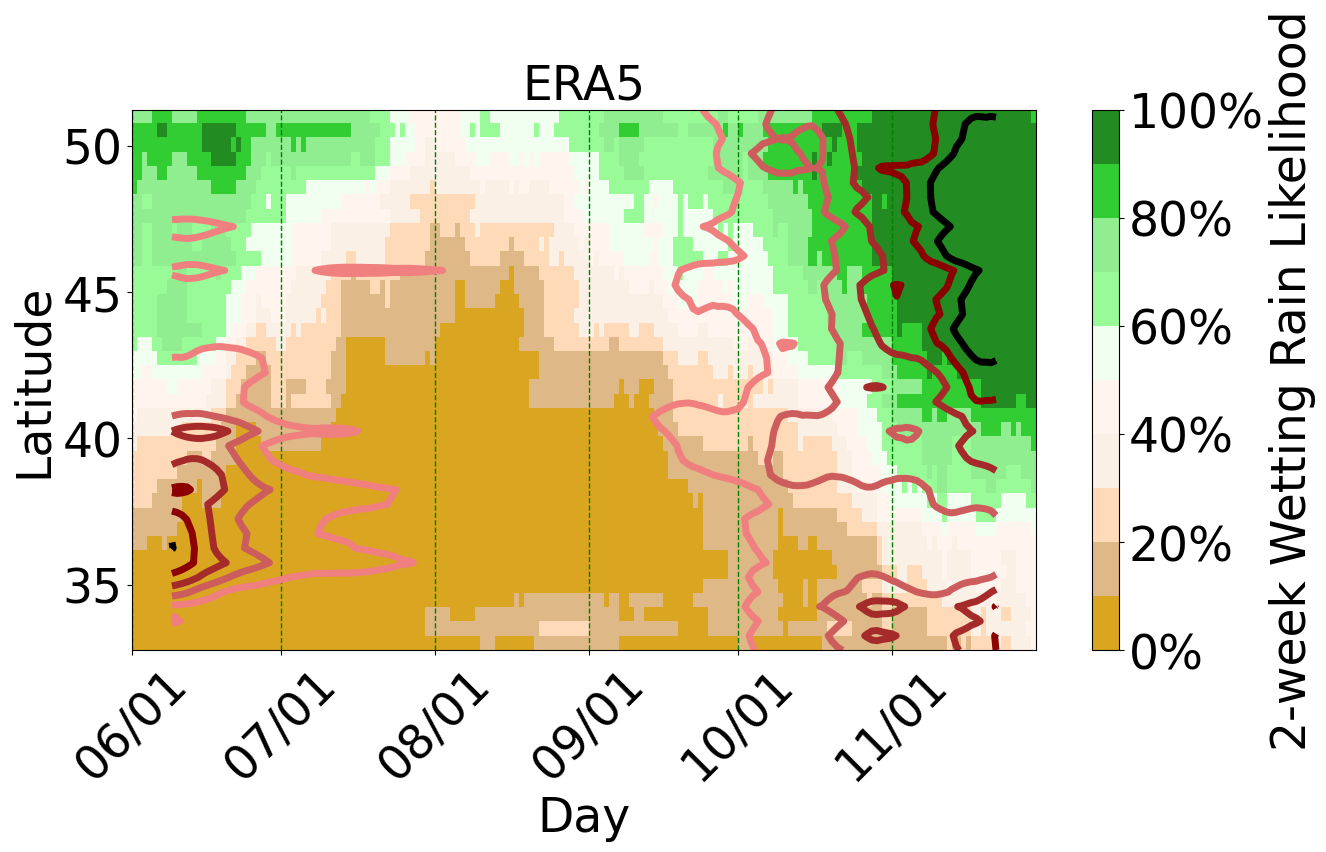

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[12,6])

# Your existing heatmap code
day_heatmap = heatmap_data['day'].values
lat2d_heatmap = heatmap_data['transect'].values
rain = heatmap_data.values

im = ax.imshow(rain, cmap=light_rain_map2, extent=[0, 182, lat2d_heatmap.min(), lat2d_heatmap.max()], aspect='auto')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('2-week Wetting Rain Likelihood', rotation=90,fontsize=34)
new_ticks = np.linspace(0, 1, 6)  # Adjust the number of ticks as needed
new_tick_labels = [f'{int(t*100)}%' for t in new_ticks]
plt.tight_layout()
cbar.set_ticks(new_ticks)
cbar.set_ticklabels(new_tick_labels)
cbar.ax.tick_params(labelsize=34)
ax.set_xlabel('Day',fontsize=34)
ax.set_ylabel('Latitude',fontsize=34)
ax.tick_params(axis='y', labelsize=34)




for tick_position in tick_positions:
    ax.axvline(tick_position, color='green', linestyle='dashed', linewidth=1)

plt.xticks(tick_positions, tick_labels, rotation=45,fontsize=34)
ax.set_xlim(0, 182)
# Contour data
smooth_wind = heatmap_data_wind.rolling(day=7,center=True).mean()
day_contour = heatmap_data_wind['day'].values
lat2d_contour = heatmap_data_wind['transect'].values
wind = smooth_wind.values

levels = np.linspace(0, 0.1, 6)  # You can adjust the number of levels as needed
linewidths = np.linspace(1, 4, 6)  # Adjust the range and values for line widths


# Create contours starting from the 61st day
#contour = ax.contour(day_contour, lat2d_contour, wind, levels=levels, colors='red', linewidths=linewidths, extent=[0, 182, lat2d_contour.min(), lat2d_contour.max()])
#ax.clabel(contour, inline=True, fontsize=12, fmt='%.2f')
# You may need to adjust the levels, colors, and linewidths based on your data

contour_level = [.02]
contour = ax.contour(day_contour, lat2d_contour, wind, levels=contour_level, colors='lightcoral', linewidths=5)

contour_level = [.04]
contour = ax.contour(day_contour, lat2d_contour, wind, levels=contour_level, colors='indianred', linewidths=5)

contour_level = [.06]
contour = ax.contour(day_contour, lat2d_contour, wind, levels=contour_level, colors='brown', linewidths=5)

contour_level = [.08]
contour = ax.contour(day_contour, lat2d_contour, wind, levels=contour_level, colors='darkred', linewidths=5)

contour_level = [.1]
contour = ax.contour(day_contour, lat2d_contour, wind, levels=contour_level, colors='black', linewidths=5)

# Set axis labels for contours
ax.set_xlabel('Day')
plt.title('ERA5',fontsize=34)
ax.set_xlim(0, 182)


cbar.set_label('2-week Wetting Rain Likelihood',fontsize=34)  # Modify the colorbar label

plt.show()